# Прогноз количества заказов такси на следующий час

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## Цель проекта

Построить модель, чтобы спрогнозировать количество заказов такси на следующий час.

## Описание данных

Данные содержат Датафрейм с информацией о компании

## План работы

1. Загрузка и подготовка данных
2. Анализ данных
3. Обучение модели
4. Проверка на тестовых данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import math

## Загрузка и подготовка данных

In [2]:
# Локальный и серверный пути к файлу
local_filepath = r"C:\Users\erofe\Downloads\taxi.csv"
server_filepath = "/datasets/taxi.csv"

# Попытка загрузки данных с локального пути
try:
    df = pd.read_csv(local_filepath, sep=',', parse_dates=[0], index_col=0)
except FileNotFoundError:
    # Если локальный путь не существует, попробовать серверный путь
    try:
        df = pd.read_csv(server_filepath, sep=',', parse_dates=[0], index_col=0)
    except FileNotFoundError:
        print('Файл не найден. Проверьте пути к файлам.')

# Вывод первых 10 строк таблицы
print(df.head(10))

# Вывод информации о таблице
print(df.info())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


На первый взгляд, с данными все хорошо пропущенных значений не наблюдается.

In [3]:
#Проводим ресемплирование по 1 часу
df = df.resample("1H").sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Вывод: В данной части работы, мы загрузили данные и провели ресемплирование по 1 часу.

## Анализ данных

Создадим дополнительную переменную скользящего среднего и скользящего стандартного отклонения, для более точного анализа

In [4]:
df["mean"] = df["num_orders"].rolling(15, closed = 'left').mean()
df["std"] = df["num_orders"].rolling(15, closed = 'left').std()

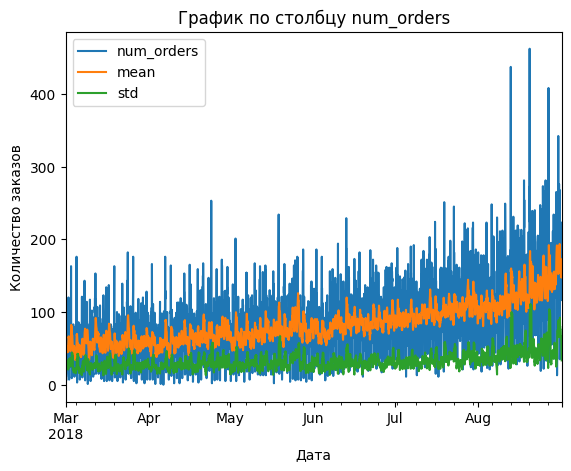

In [5]:
df.plot(title = 'График по столбцу num_orders')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Выборка достаточно нестационарна, но для точной оценки надо еще оценить разность ряда

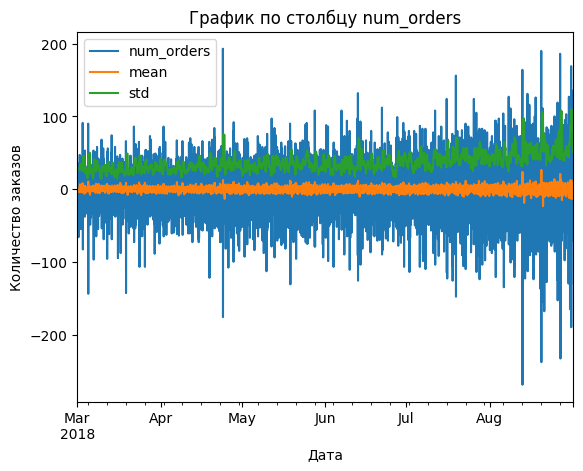

In [6]:
df0 = df - df.shift()
df0["mean"] = df0["num_orders"].rolling(15, closed = 'left').mean()
df0["std"] = df0["num_orders"].rolling(15, closed = 'left').std()
df0.plot(title = 'График по столбцу num_orders')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

По графикам видно, что наша выборка нестационарна

In [7]:
#Удалим ненужные нам признаки
df = df.drop(['std', 'mean'], axis=1)
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


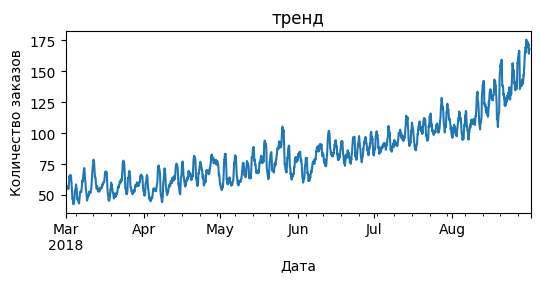

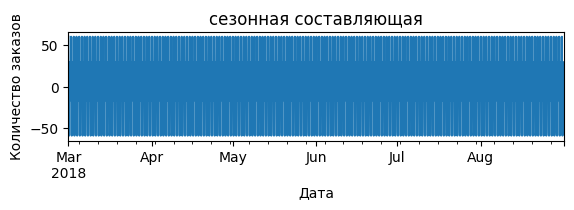

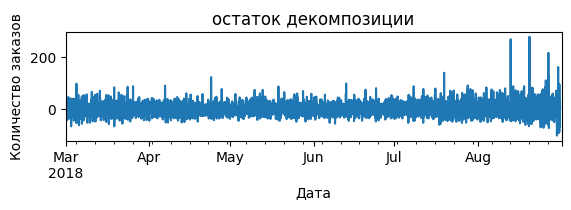

<Figure size 640x480 with 0 Axes>

In [8]:
#Строим необходимые графики
decomposed = seasonal_decompose(df)
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('сезонная составляющая')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('остаток декомпозиции')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()
plt.tight_layout()

Сезонная составляющая не влияет на количество заказов, в то время, как линия тренда показывает, что количество заказов становится все больше и больше.

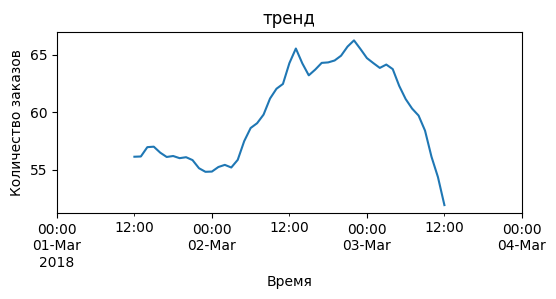

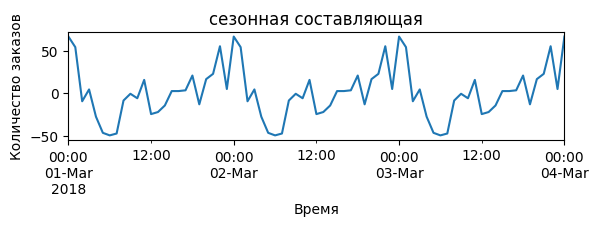

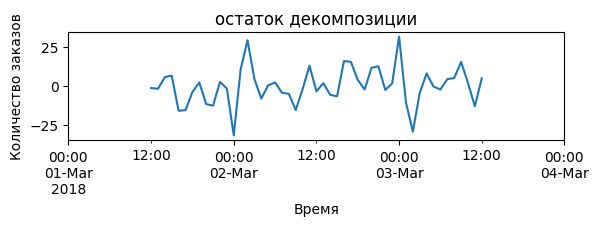

<Figure size 640x480 with 0 Axes>

In [9]:
#Строим необходимые графики
decomposed = seasonal_decompose(df['2018-03-01 00:00:00':'2018-03-04 00:00:00'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('тренд')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('сезонная составляющая')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('остаток декомпозиции')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()
plt.tight_layout()

Рассмотрев количество заказов в разрезе 3 суток, мы выяснили, что сезонность здесь присутствует суточная, самое большое количество заказов приходится на время около 00.00, а самое маленькое примерно на 6 утра. Это скорее всего связано с количеством прибывающих рейсов в аэропорт в данное время, и с нежеланием или невозможностью проезда на общественном транспорте в позднее время.

Вывод: В данной части работы был проведен анализ данных, выяснено, что выборка является стационарной и были построены и проанализированны графики тренда, сезонной составляющей и остатка декомпозиции.

## Обучение и проверка модели

In [10]:
#Создаем новые признаки для обучения молдели
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(window=rolling_mean_size).mean()

In [11]:
make_features(df,24,15)
df

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,156.133333
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,147.333333
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,152.400000


In [12]:
# Разделяем данные на признаки и целевую переменную
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

# Разбиение данных на обучающую (90%) и тестовую (10%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [13]:
# Определение количественных и категориальных признаков
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

In [14]:
# Создание трансформатора для количественных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Создание пайплайна предварительной обработки данных и поиска лучшей модели
models = {
    'LinearRegression': {'model': LinearRegression(), 'param_grid': {}},
    'DecisionTreeRegressor': {'model': DecisionTreeRegressor(random_state=42), 
                              'param_grid': {'regressor__max_depth': [5, 10, 15]}},
    'RandomForestRegressor': {'model': RandomForestRegressor(random_state=42), 'param_grid': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__max_depth': [5, 10, 15]
        }}
}

In [15]:
results = {}

# Изменим параметр cv на TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for model_name, config in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, config['param_grid'], cv=tscv, scoring='neg_mean_squared_error')
    
    grid_search.fit(X_train, y_train)
    cv_scores = cross_val_score(grid_search, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    
    print(f"{model_name}: Лучшие параметры - {grid_search.best_params_}")
    print(f"{model_name}: Лучшая модель - {grid_search.best_estimator_}")
    
    # Вывод средней оценки кросс-валидации
    print(f"{model_name}: Средняя оценка кросс-валидации - {math.sqrt(abs(cv_scores).mean())}\n")
    
    results[model_name] = {
        'best_params': grid_search.best_estimator_['regressor'].get_params(),
        'best_model': grid_search.best_estimator_,
        'cv_scores': cv_scores
    }

LinearRegression: Лучшие параметры - {}
LinearRegression: Лучшая модель - Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
       'lag_23', 'lag_24', 'rolling_mean'],
      dtype='object'))])),
                ('regressor', LinearRegression())])
LinearRegression: Средняя оценка кросс-валидации - 28.677254398509774

DecisionTreeRegressor: Лучшие па

Вывод: Лучшей моделью по нужной нам метрике RMSE стал RandomForestRegressor, именно его мы и будем тестировать далее.

## Проверка на тестовых данных

In [16]:
# Извлекаем лучшую модель RandomForestRegressor
best_random_forest_model = results['RandomForestRegressor']['best_model']

# Предсказания на тестовой выборке
y_test_pred = best_random_forest_model.predict(X_test)

# Рассчитываем RMSE на тестовой выборке
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"RandomForestRegressor на тестовой выборке: RMSE - {test_rmse}")

RandomForestRegressor на тестовой выборке: RMSE - 24.159514572583866


Вывод: была проеведена проверка на тестовых данных, модель не переобучилась и показывает результаты, даже лучшие, чем на тренировочной выборке (скорее всего это связано с масштабом выборок).

## Общий вывод

Была проведена работа разработке модели для прогноза количества заказов на следующий час. Для начала была проведена загрузка и сэмплирование данных. Далее был проведен анализ имеющегося временного ряда, выясненно, что он стационарный и не подверженный сезонности. Далее были обучены несколько моделей с разными гиперпараметрами и найдена лучшая - RandomForestRegressor. Она же была проверена на тестовой выборке и так же показала высокие результаты.